# Self-editing correction pipeline

The purpose of this notebook is to correct for self-editing activity of PAM-flexible base editors, as detailed in the following bioRxiv preprint: Activity-based selection for enhanced base editor mutational scanning, Kaplan et al 2024. <br> <br>
Please refer to the README file for instructions to generate the necessary files. This code will output a graph for initial analysis of the level of self-editing in your screen, as well as a final read counts file that can be used for further screen analysis.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from poola import core as pool
from scipy import stats
import matplotlib as mpl
import gpplot as gpp
import seaborn as sns
gpp.set_aesthetics()

Matplotlib is building the font cache; this may take a moment.


In [5]:
def newcol_name(unexpected_count, condition_df):
    #renames columns with barcodes based on condition map
    #inputs:
        #unexpected_count: PoolQ-generated dataframe containing the most frequent (1e6, typically) sgRNA sequences that are not found in the reference file
        #condition_df: 2-column dataframe linking P7 sequencing barcode to associated sample
    #outputs: edits in place
    condition_df[1] = condition_df[1].replace(np.nan, 'Nothing')
    new_cols = []
    for col in unexpected_count.columns:
        if col in condition_df[0].to_list():
            new_col = condition_df[condition_df[0] == col][1].to_list()
        else: 
            new_col = [col]
        new_cols.extend(new_col)   
    unexpected_count.columns = new_cols
    
def regex_seq(reference_df, guide_seq_col = 'sgRNA Target Sequence', 
              chr_change = 'A', regex_pattern = '[AG]'):
    #adds a column to the reference file with regex representing all possible combinations of A>G (or C>T if CBE) edits that may occur within a guide
    #to evaluate CBE self-editing, implement the following changes above: chr_change='C', regex_pattern='[CT]'
    #inputs:
        #reference_df: 5-column dataframe consisting of sgRNA Target Sequence, Target Gene ID, Target Gene Symbol, A-G edits, and C-T edits
    #outputs: edits in place    
    regex_list = []
    for seq in reference_df[guide_seq_col]:
        pos_a = [pos for pos, char in enumerate(seq) if char == chr_change]
        temp = list(seq)
        for pos in pos_a:
            temp[pos] = regex_pattern
        string = "".join(temp)
        regex_list.append(string)
    reference_df['regex'] = regex_list

def regex_match(reference_df, unexpected_count, 
                reference_regex_col = 'regex', reference_seq_col = 'sgRNA Target Sequence',
                unexpected_count_seq_col = 'Sequence'):
    #makes a dictionary mapping each guide to each of mismatched sequences seen in unexpected counts file
    #inputs:
        #reference_df: as stated previously, including new regex column from regex_seq function
        #unexpected_count: as stated previously, including mapped column names from newcol_name function
    #outputs: 
        #long_list: list of all possible sgRNA sequences given any A>G or C>T editing
        #my_dict: dictionary with reference sgRNAs as keys and possible self-edited sgRNAs as values
    long_list = []  
    my_dict = {}
    for seq in range(reference_df.shape[0]):
        r = re.compile(reference_df[reference_regex_col][seq])
        newlist = list(filter(r.match, unexpected_count[unexpected_count_seq_col].to_list()))
        long_list.extend(newlist)
        my_dict[reference_df[reference_seq_col][seq]] = newlist
    return long_list, my_dict

def df_align(my_dict):
    #creates a dataframe with each row as a reference sgRNA and self-edited sgRNA, location of mismatch and the number of mismatches between the guide and the mismatched sequence 
    #input: 
        #my_dict: dictionary created in regex_match function
    #outputs:
        #df: a dataframe with each row as a reference sgRNA and mapped self-edited sgRNA
        #pos_mismatch: list of self-editing location
    df = pd.DataFrame(columns =['guide_seq','mismatch_seq', 'loc_mismatch', 'number_mis_seq'])
    pos_mismatch = []
    for key, values in my_dict.items():
        if len(values)>0:
            for val in values:
                loc_mismatch = [i for i in range(len(key)) if key[i] != val[i]]
                pos_mismatch.extend(loc_mismatch)
                row_to_append = pd.DataFrame([{'guide_seq':key, 'mismatch_seq':val,
                                               'loc_mismatch':loc_mismatch,'number_mis_seq':len(loc_mismatch)}])
                df = pd.concat([df,row_to_append])
        else:
            continue
    return df, pos_mismatch

def percent_mismatch(cols_to_sum, counts, unexpected_count, align_to_df):
    #this function takes the unexpected sequences counts and total counts per guide and finds the percent unexpected reads/guide
    #inputs:
        #cols_to_sum: list of columns to be used for self-editing analysis (can be all or subset)
        #counts: PoolQ-generated dataframe containing read counts for each condition. This only includes sgRNA sequences that are found in the reference file
        #unexpected_count: as previously described with newcol_name function, subsetted to cols_to_sum if used
        #align_to_df: dataframe generated as "df" in df_align function
    #outputs:
        #sum_by_sg: dataframe containing 4 columns: Construct Barcode, mismatch_total, sg_count_total, percent (percent self-edited reads of total reads)
    counts['sg_count_total'] = counts[cols_to_sum].sum(axis=1)
    mismatch_to_norm = []
    mismatch_to_norm = pd.merge(counts, align_to_df, right_on="guide_seq", left_on='Construct Barcode',how="left")
    
    mismatch_to_norm = pd.merge(mismatch_to_norm, unexpected_count, right_on="Sequence", left_on='mismatch_seq',how="left")
    col_to_keep = ['Construct Barcode', 'mismatch_seq', 'sg_count_total', 'Total']
    mismatch_simple = mismatch_to_norm[col_to_keep]
    mismatch_simple = mismatch_simple.rename(columns={'Total': 'mismatch_total'})
    
    unique_sg = mismatch_simple.drop_duplicates(subset=['Construct Barcode'])
    col_to_keep_2 = ['Construct Barcode', 'sg_count_total']
    unique_sg = unique_sg[col_to_keep_2]
    sum_by_sg = mismatch_simple.groupby('Construct Barcode')['mismatch_total'].sum().reset_index()
    sum_by_sg = pd.merge(sum_by_sg, unique_sg, on='Construct Barcode')
    sum_by_sg['sg_count_total'] = sum_by_sg['mismatch_total']+sum_by_sg['sg_count_total']
    sum_by_sg['percent'] = sum_by_sg['mismatch_total']/sum_by_sg['sg_count_total']*100
    return sum_by_sg

def across_guide(align_to_df, unexpected_count, sum_by_sg):
    #this function generates the self-editing frequencies at each nucleotide across the sgRNA
    #inputs:
        #align_to_df: as stated previously in percent_mismatch function
        #unexpected_count: as stated previously in percent_mismatch function
        #sum_by_sg: as returned by percent_mismatch function
    #outputs:
        #sgrna_edit_pos: contains a unique row for each individual self-editing mismatch and shows self-editing by nucleotide along sgRNA percentage
    editing_by_pos = pd.merge(unexpected_count, align_to_df, left_on='Sequence',right_on="mismatch_seq", how="right")
    col_to_keep = ['guide_seq', 'mismatch_seq', 'loc_mismatch','Total']
    editing_by_pos = editing_by_pos[col_to_keep]
    editing_by_pos = editing_by_pos.rename(columns={'Total': 'mm_total'})
    sgrna_exploded = editing_by_pos.explode('loc_mismatch').reset_index(drop=True)
    sgrna_edit = sgrna_exploded.groupby(['guide_seq','loc_mismatch']).sum(numeric_only = True).reset_index()
    sgrna_edit_pos = pd.merge(sgrna_edit, sum_by_sg, left_on='guide_seq',right_on='Construct Barcode',how="right")
    sgrna_edit_pos['editing_per_nt'] = sgrna_edit_pos['mm_total']/sgrna_edit_pos['sg_count_total']*100
    return sgrna_edit_pos

def mapping_adding(unexpected_count, align_to_df, counts):
    #this function adds the unexpected sequence read counts to their mapped sequence read counts, generating a counts file that can be used for future analysis
    #inputs:
        #align_to_df: as stated previously in percent_mismatch function
        #unexpected_count: as stated previously in percent_mismatch function
        #counts: as stated previously in percent_mismatch function
    #outputs:
        #counts_merged_final: corrected read counts file (dataframe similar to original counts file, but includes mapped self-edited sgRNAs). This file should contain the same number of rows as the original counts file.
    unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()
    unexpected_count_matched = pd.merge(unexpected_count_grouped, align_to_df, left_on='Sequence', right_on='mismatch_seq',
                                   how='right')
    unexpected_count_final = unexpected_count_matched.groupby('guide_seq').sum().reset_index()
    
    counts_merged = pd.merge(counts, unexpected_count_final, left_on='Construct Barcode', right_on='guide_seq',
                         suffixes=('_df2', '_df1'))
    exclude_columns = {'Construct Barcode','Construct IDs','Potential IDs','Sequence','Total','guide_seq','mismatch_seq','loc_mismatch','number_mis_seq'}
    columns_to_sum = set(counts.columns).intersection(set(unexpected_count_final.columns)) - exclude_columns

    for col in columns_to_sum:
        counts_merged[col] = counts_merged[f'{col}_df2'] + counts_merged[f'{col}_df1']
        counts_merged.drop([f'{col}_df2', f'{col}_df1'], axis=1, inplace=True)
    #retrieve guides that did not undergo any self editing (no match in mismatched counts)
    filtered_counts = counts[~counts['Construct Barcode'].isin(counts_merged['Construct Barcode'])].reset_index()

    counts_merged_final = pd.concat([counts_merged, filtered_counts], ignore_index=True).reindex(columns=counts_merged.columns)
    return counts_merged_final

### Example with sample data

Sample data description: <br>Cell line: A549 <br> Base editor: ABE8e (RDA867) <br> Libraries: CP2087 (repA), CP2088 (repB) --these use different splice sgRNAs but the same TP53 library and drug conditions and thereby function as replicates. These samples underwent activity-based selection.
<br>  Samples taken on day 21

In [6]:
#load data
condition = pd.read_csv('conditions_sample.csv', header = None)
reference = pd.read_csv('reference_sample.csv')
counts = pd.read_table('counts_sample.txt')

#unzip unexpected counts file
import zipfile
zip_file_path = 'unexpected_counts_sample.txt.zip'
extract_to = '.'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

unexpected_count = pd.read_table('unexpected_counts_sample.txt')


In [7]:
#run functions to map unexpected sequences to self-edited sgRNAs
newcol_name(unexpected_count, condition)
regex_seq(reference)
seq_match, dic_seq_match = regex_match(reference, unexpected_count)
align_to_df, AG_pos_mismatch= df_align(dic_seq_match)

In [8]:
#limit scope of conditions if desired (here we limit to only TP53-targeting genes from the dropout condition)
cols = ['Construct Barcode','Construct IDs','A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']
counts_DO = counts[cols]
counts_DO = counts_DO[counts_DO['Construct IDs']=='ENSG00000141510'] #TP53

unexpected_count_DO = unexpected_count[['Sequence', 'A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']]

In [9]:
#sum to obtain the total number of self-edited sgRNAs of these conditions
cols_to_sum = ['A549_RDA867CP2087DropoutA21', 'A549_RDA867CP2088DropoutA21']
unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_79893/708266955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unexpected_count_DO['Total']=unexpected_count_DO[cols_to_sum].sum(axis=1)


In [10]:
#generate the percent self-edited sgRNAs of total sgRNA reads
sum_by_sg_abe_activity = percent_mismatch(cols_to_sum, counts_DO, unexpected_count_DO, align_to_df)

#generate the self-editing frequencies at each nucleotide across the sgRNA
sgrna_edit_abe_pos_activity = across_guide(align_to_df, unexpected_count_DO, sum_by_sg_abe_activity)

Text(0.5, 1.0, 'ABE activity-based selection self-editing across sgTP53')

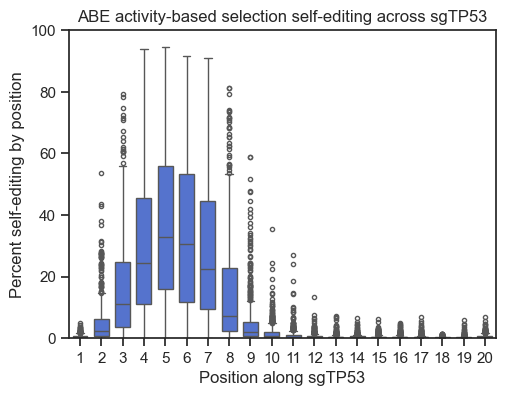

In [11]:
#to briefly observe the amount of self-editing, plot self-editing frequencies at each nucleotide across the sgRNA
fig, ax = plt.subplots(figsize=(5.5, 4))
a = sns.boxplot(data=sgrna_edit_abe_pos_activity, y="editing_per_nt", x="loc_mismatch", color='royalblue',width=.7,fliersize=3)
a.set_xlabel("Position along sgTP53")
plt.xticks(ticks=range(20), labels=range(1, 21))
a.set_ylim([0,100])
plt.yticks([0, 20, 40, 60, 80, 100])
a.set_ylabel("Percent self-editing by position")
a.set_title("ABE activity-based selection self-editing across sgTP53")

In [12]:
#create read counts file by sgRNA that accounts for self-editing
counts_merged_final = mapping_adding(unexpected_count, align_to_df, counts)
#counts_merged_final.to_csv('FILEPATH.csv')

/var/folders/nm/6_wl7tx50tq5bqfp8vzf4m6r0000gq/T/ipykernel_79893/3352882001.py:127: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  unexpected_count_grouped = unexpected_count.groupby(unexpected_count.columns, axis=1).sum()
